In [45]:
import pandas as pd
import numpy as np
import keras
import gensim
import matplotlib.pyplot as plt

In [11]:
tweetdata = pd.read_csv("data/raw/testdata.manual.2009.06.14.csv", header=None, encoding="ISO-8859-1")

In [12]:
len(tweetdata)

498

In [13]:
tweetdata.columns=['polarity', 'id', 'date', 'source', 'user', 'text']

In [14]:
tweetdata.head()

,polarity,id,date,source,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


### Create Hashtag Tweets Dataset

In [21]:
hashtag_ids = []
for i in range(len(tweetdata[5])):
    if '#' in tweetdata[5][i]:
               hashtag_ids.append(i)

In [22]:
len(hashtag_ids)

36812

In [32]:
len(hashtag_ids)/len(tweetdata)

0.021213531494140625

In [23]:
hashtag_tweets = tweetdata.iloc[hashtag_ids]

In [24]:
len(hashtag_tweets)

36812

In [25]:
# hashtag_tweets.to_csv('hashtag_tweets.36812.csv')

# Cleaning

Note to self: start with naive/convenient implementation. When hosting as a service, look to improve efficiency with faster methods.

A lot of the following is determined by domain, topic, data type, data source, experience, and language.


Remove
- integers
- punctuation
- url
- html tags
- other characters

In [ ]:
# @\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+

In [7]:
# 1/21/19 https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [15]:
original_tweetdata = tweetdata.copy()

In [16]:
tweetdata = standardize_text(tweetdata, 'text')

In [17]:
original_tweetdata.head()

,polarity,id,date,source,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [31]:
original_tweetdata.text[5]

"@richardebaker no. it is too big. I'm quite happy with the Kindle2."

In [32]:
tweetdata.text[5]

" no  it is too big  i'm quite happy with the kindle2 "

In [31]:
# tweetdata.to_csv("1600000.cleaned.url.at.csv")

# Preprocessing

In [33]:
tweetdata.groupby('polarity').count()

,id,date,source,user,text
polarity,,,,,
0,177,177,177,177,177
2,139,139,139,139,139
4,182,182,182,182,182


# Embedding

In [6]:
# tweetdata = pd.read_csv("1600000.cleaned.url.at.csv", index_col=0)

/Users/rexlintc/anaconda/envs/cs61c/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [35]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

tweetdata["tokens"] = tweetdata["text"].apply(tokenizer.tokenize)
tweetdata.head()

,polarity,id,date,source,user,text,tokens
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,i loooooooovvvvvveee my kindle2 not that the...,"[i, loooooooovvvvvveee, my, kindle2, not, that..."
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,reading my kindle2 love it lee childs i...,"[reading, my, kindle2, love, it, lee, childs, ..."
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"ok, first assesment of the kindle2 it fuck...","[ok, first, assesment, of, the, kindle2, it, f..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,you'll love your kindle2 i've had mine for a...,"[you, ll, love, your, kindle2, i, ve, had, min..."
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,fair enough but i have the kindle2 and i th...,"[fair, enough, but, i, have, the, kindle2, and..."


In [36]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in tweetdata["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in tweetdata["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

6629 words total, with a vocabulary size of 2015
Max sentence length is 31


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = tweetdata["text"].tolist()
list_labels = tweetdata["polarity"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [39]:
X_test_counts

<100x1713 sparse matrix of type '<class 'numpy.int64'>'
	with 843 stored elements in Compressed Sparse Row format>

In [42]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [43]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.660, precision = 0.665, recall = 0.660, f1 = 0.659


In [46]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

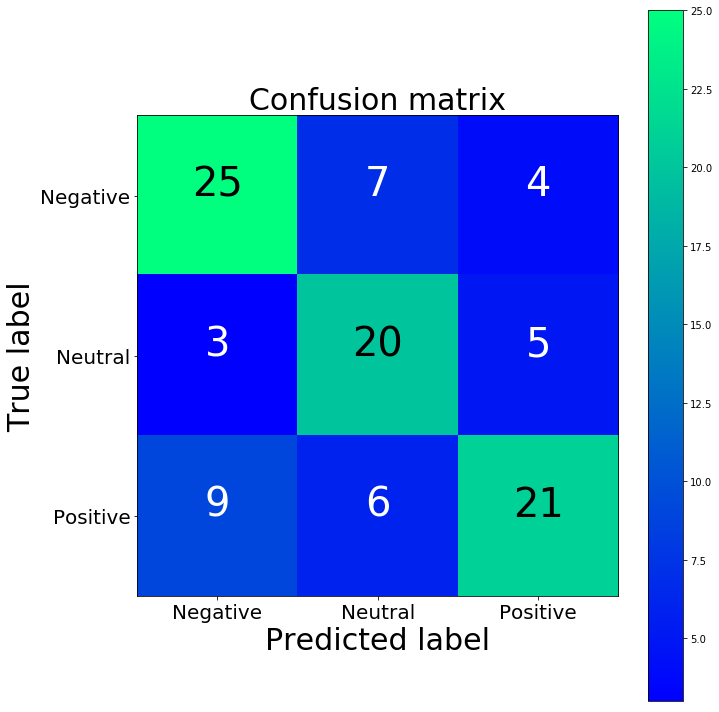

[[25  7  4]
 [ 3 20  5]
 [ 9  6 21]]


In [47]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [41]:
import numpy as np
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.", len(model), " words loaded!")
    return model

In [15]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Positive')
            green_patch = mpatches.Patch(color='blue', label='Negative')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

<Figure size 1600x1600 with 1 Axes>

In [55]:
# Hashtag REGEX